# TD1 - Exercice 1
Soit un signal sonore périodique dont la pression acoustique instantanée est donnée sur la figure ci-dessous.

1. À partir du calcul de la pression acoustique efficace, déterminer le niveau de pression.
2. Tracer le spectre de la pression acoustique pour des fréquences allant jusqu’à 700 Hz.
3. Donner le spectre en bandes d’octave de ce son.

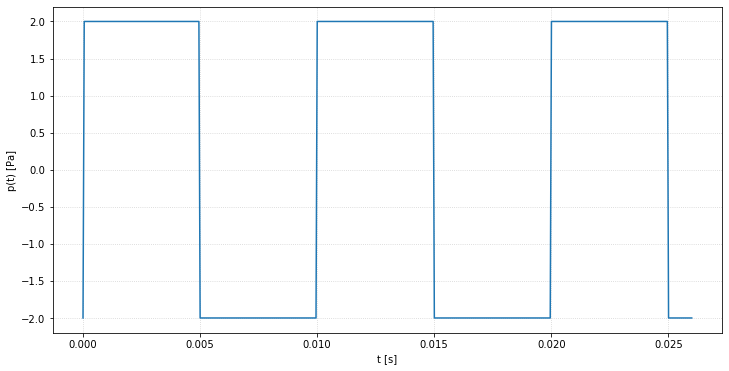

Button(description='Écouter', style=ButtonStyle())

In [1]:
"""
INSA Lyon - Département Génie Civil et Urbanisme
Travaux dirigés d'acoustique du bâtiment

Copyright © 2021 Christian Obrecht <christian.obrecht@insa-lyon.fr>

Ce document est distribué sous licence Creative Commons CC-BY-NC-SA
"""

from math import remainder, log10, pi, sin, sqrt
from numpy import linspace, array, int16
from simpleaudio import WaveObject
from ipywidgets import interactive, HBox, VBox, Button, IntSlider
import matplotlib.pyplot as plt

# Représentation graphique
def draw(x, lx, y, ly, size = (12, 6), diagram = plt.plot):
    plt.figure(figsize = size)
    plt.xlabel(lx)
    plt.ylabel(ly)
    plt.grid(alpha =.6, linestyle =':')
    diagram(x, y)
    plt.show()
    
# Rendu sonore
def play(p, duration):
    rate = 44100
    sampling = linspace(0, duration, duration*rate)
    # Conversion du signal en entiers signés 16 bits avec normalisation
    # par l'amplitude maximale de la première harmonique
    audio = array([p(t)*0x7FFF*pi/8 for t in sampling]).astype(int16)
    wave = WaveObject(audio, 1, 2, rate)
    wave.play()

T = 0.01 # Période

# Pression acoustique instantanée
def p(t):
    return 2 if remainder(t, T) > 0 else -2

x = linspace(0, 0.026, 500) # Temps
y = [p(t) for t in x] # Pression
draw(x, 't [s]', y, 'p(t) [Pa]')

def play_original(_):
    play(p, 2)

button = Button(description = 'Écouter')
button.on_click(play_original)
button

# 1. Calcul du niveau de pression
## Pression acoustique efficace
$$p_e^2=\frac{1}{T}\int_0^T p^2(t) {\rm d}t$$

Pour tout $t$, $p^2(t)=4$ donc $p_e=2$ Pa.

## Niveau de pression
$$L_p=10\log\left(\frac{p_e^2}{p_0^2}\right)=10\log\left(\frac{2^2}{\left(2\times10^{-5}\right)^2}\right)=100\textrm{ dB}$$

# 2. Spectre
## Série de Fourier d'une fonction $T$-périodique
$$f(x)=a_{0}+\sum _{n=1}^{\infty}\left(a_{n}\cos\left(nx{\frac {2\pi }{T}}\right)+b_{n}\sin\left(nx{\frac {2\pi }{T}}\right)\right)$$
$$a_{0}={\frac{1}{T}}\int_{-T/2}^{T/2}f(t)\,\mathrm{d}t$$
Pour $n>0$ :
$$a_{n}={\frac{2}{T}}\int_{-T/2}^{T/2}f(t)\cos\left(nt{\frac{2\pi }{T}}\right)\,\mathrm{d}t$$

$$b_{n}={\frac{2}{T}}\int_{-T/2}^{T/2}f(t)\sin\left(nt{\frac{2\pi }{T}}\right)\,\mathrm{d}t$$

## Calcul des coefficients

Pour tout $n$, $a_n = 0$ ($\,p$ fonction impaire).

$$b_{n}={\frac{2}{T}}\int_{-T/2}^{T/2}p(t)\sin \left(nt{\frac {2\pi }{T}}\right)\,\mathrm{d}t$$

$$b_{n}={\frac{4}{T}}\left(\int_{0}^{T/2}\sin\left(nt{\frac {2\pi }{T}}\right)\,\mathrm{d}t-\int_{-T/2}^{0}\sin\left(nt{\frac{2\pi }{T}}\right)\,\mathrm {d}t\right)$$

$$b_{n}={\frac{2}{n\pi}}\left(\left[-\cos\left(nt{\frac{2\pi}{T}}\right)\right]_{0}^{T/2}-\left[-\cos\left(nt{\frac{2\pi}{T}}\right)\right]_{-T/2}^{0}\right)$$

$$b_{n}={\frac{4}{n\pi}}\left(1-\cos(n\pi)\right)$$

$$b_n = \frac{8}{n\pi}\textrm{ pour }n =1,\ 3,\ 5,\ 7\textrm{ et }b_n=0\textrm{ pour }n =2,\ 4,\ 6$$

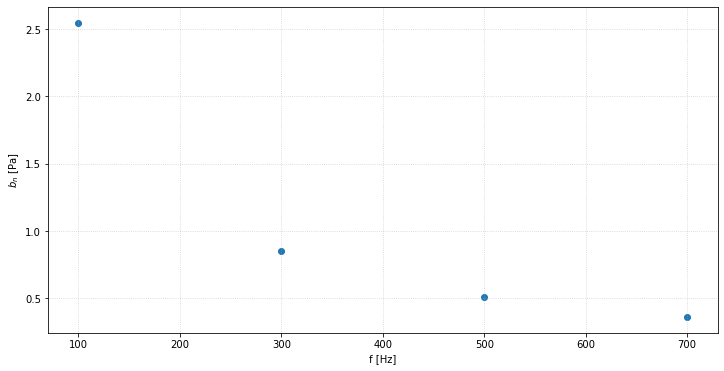

In [2]:
X = [n/T for n in range(1, 8, 2)] # Fréquences
Y = [8/(n*pi) for n in range(1, 8, 2)] # Coefficients
draw(X, 'f [Hz]', Y, r'$b_n$ [Pa]', diagram = plt.scatter)

## Somme partielle
$$p_n(t)=\frac{8}{n\pi}\sin\left(nt{\frac{2\pi }{T}}\right)\textrm{ pour }n\textrm{ impair},\ p_n(t)=0\textrm{ pour }n\textrm{ pair}$$
$$p(t)\approx\sum _{n=1}^{4}p_{2n-1}$$

In [3]:
from functools import lru_cache

@lru_cache
def pn(n, t):
    return 8*sin(n*t*2*pi/T)/(n*pi)

# Somme partielle
@lru_cache
def pa(N, t):
    return sum(pn(2*n-1, t) for n in range(1, N+1))

# Note : le recours à lru_cache permet d'accélerer le calcul en augmentant
# l'utilisation de la mémoire cache

def plot(N):
    z = [pa(N, t) for t in x]
    plt.figure(figsize=(12, 6))
    plt.xlabel('t [s]')
    plt.ylabel('p(t) [Pa]')
    plt.ylim([-3,3])
    plt.grid(alpha =.6, linestyle =':')
    plt.plot(x, y,  x, z)
    plt.show()
    return N

slider = interactive(plot, N = IntSlider(min = 1, max = 25, value = 1))

def play_partial(_):
    play(lambda t: pa(slider.result, t), 2)

partial = Button(description = "Somme partielle")
partial.on_click(play_partial)

original = Button(description = "Son d'origine")
original.on_click(play_original)

HBox([slider, VBox([partial, original])])

# 3. Spectre en bandes d'octave
## Bandes d'octave
$$\left[\frac{f_m}{\sqrt{2}},\ f_m\sqrt{2}\right]\textrm{ avec }f_m\textrm{ fréquence médiane}$$

In [4]:
fm = [125*2**n for n in range(6)]
fa = [f/sqrt(2) for f in fm]
fb = [f*sqrt(2) for f in fm]
fc = [90, 180, 350, 700, 1400, 2800]
fd = [180, 350, 700, 1400, 2800, 5600]
for m, a, b, c, d in zip(fm, fa, fb, fc, fd):
    print(f"{m:-4g} Hz : [{a:-6.1f}, {b:-6.1f}] -> [{c:-4g}, {d:-4g}]")

 125 Hz : [  88.4,  176.8] -> [  90,  180]
 250 Hz : [ 176.8,  353.6] -> [ 180,  350]
 500 Hz : [ 353.6,  707.1] -> [ 350,  700]
1000 Hz : [ 707.1, 1414.2] -> [ 700, 1400]
2000 Hz : [1414.2, 2828.4] -> [1400, 2800]
4000 Hz : [2828.4, 5656.9] -> [2800, 5600]


## Pression acoustique efficace des harmoniques ($n$ impair)
$$p_{e,n}^2=\frac{1}{T}\int_0^T p_n^2(t) {\rm d}t$$

$$p_{e,n}^2=\frac{1}{T}\left(\frac{8}{n\pi}\right)^2\int_0^T\sin^2\left(nt{\frac{2\pi}{T}}\right) {\rm d}t$$

$$p_{e,n}^2=\frac{1}{2T}\left(\frac{8}{n\pi}\right)^2\int_0^T\left(1-\cos\left(nt{\frac{4\pi}{T}}\right)\right){\rm d}t$$

$$p_{e,n}^2=\frac{1}{2}\left(\frac{8}{n\pi}\right)^2$$

## Niveaux de pression par harmonique

$$L_n=10\log\left(\frac{p_{e,n}^2}{p_0^2}\right)$$

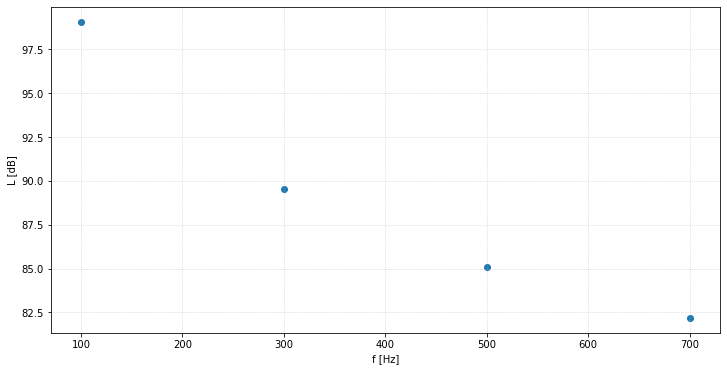

In [5]:
p0 = 2e-5 # Pression de référence
L = [10*log10(.5*(8/(n*pi))**2/p0**2) for n in range(1, 8, 2)] # Niveaux de pression
draw(X, 'f [Hz]', L, 'L [dB]', diagram = plt.scatter)

## Niveaux de pression par octave
$$L(125)=L_1,\ L(250)=L_3,\ L(500)=L_5\oplus L_7=10\log\left(10^\frac{L_5}{10}+10^\frac{L_7}{10}\right)$$

In [6]:
# Somme logarithmique
def lsum(*L):
    return 10*log10(sum(10**(l/10) for l in L))

print(f"L(125) = {L[0]:4.1f} dB")
print(f"L(250) = {L[1]:4.1f} dB")
print(f"L(500) = {lsum(L[2],L[3]):4.1f} dB")

L(125) = 99.1 dB
L(250) = 89.5 dB
L(500) = 86.9 dB
